# 1. The Dataset
The first thing we need is of course the dataset. I found the dataset here and it is basically a collection extracted from  JawwyTV content puplished by STC. The IPTV dataset contains the following features and it has more than 70 million rows and the size of data is more than 1 terabyte (TB), the data are:
*  User ID
* SESSION START (DATE/TIME)
* SESSION DURATION
* PROGRAM NAME
* PROGRAM DESCRIPTION
* PREOGRAM GENRE
* PROGRAM CLASS
* SERIES TITLE
* SERIES NAME
* Episode title
* Episode number




In [75]:
!pip install umap-learn[plot]

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')
# Feature Engineering
from gensim.models import Word2Vec 


In [85]:
# importing data and drop the ID column
df= pd.read_csv("/content/Final_Dataset.txt")
df = df.iloc[: , 1:]

In [86]:
# viweing the data head
df.head()

,date_,user_id_maped,program_name,duration_seconds,program_class,season,episode,program_desc,program_genre,series_title,hd,original_name
0,2017-05-27,26138,100 treets,40,MOVIE,0,0,Drama Movie100 Streets,Drama,0,0,100 treets
1,2017-05-21,7946,Moana,17,MOVIE,0,0,Animation MovieMoana (HD),Animation,0,1,Moana
2,2017-08-10,7418,The Mermaid Princess,8,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess
3,2017-07-26,19307,The Mermaid Princess,76,MOVIE,0,0,Animation MovieThe Mermaid Princess (HD),Animation,0,1,The Mermaid Princess
4,2017-07-07,15860,Churchill,87,MOVIE,0,0,Biography MovieChurchill (HD),Biography,0,1,Churchill


In [87]:
# viweing the data tail
df.tail()

,date_,user_id_maped,program_name,duration_seconds,program_class,season,episode,program_desc,program_genre,series_title,hd,original_name
3486919,2017-06-01,25923,Nan and Lili Ep.,194,SERIES/EPISODES,1,40,"Animation MovieNan and Lili, Season 1, Ep. 41",Animation,0,0,Nan and Lili
3486920,2018-04-13,29866,Legion Chapter,2056,SERIES/EPISODES,1,4,Action MovieChapter 4 (HD),Action,0,0,Legion
3486921,2017-07-05,24962,Slugterra lugball,152,SERIES/EPISODES,1,28,Animation MovieSlugball (HD),Animation,0,0,Slugterra
3486922,2017-04-15,10259,Friends The One With The Tea Leaves,17,SERIES/EPISODES,8,17,Comedy MovieThe One With The Tea Leaves (HD),Comedy,0,1,Friends
3486923,2018-02-23,20238,An Inconvenient equel: Truth to Power,98,MOVIE,0,0,Documentary MovieAn Inconvenient Sequel: Truth...,Documentary,0,1,An Inconvenient eq


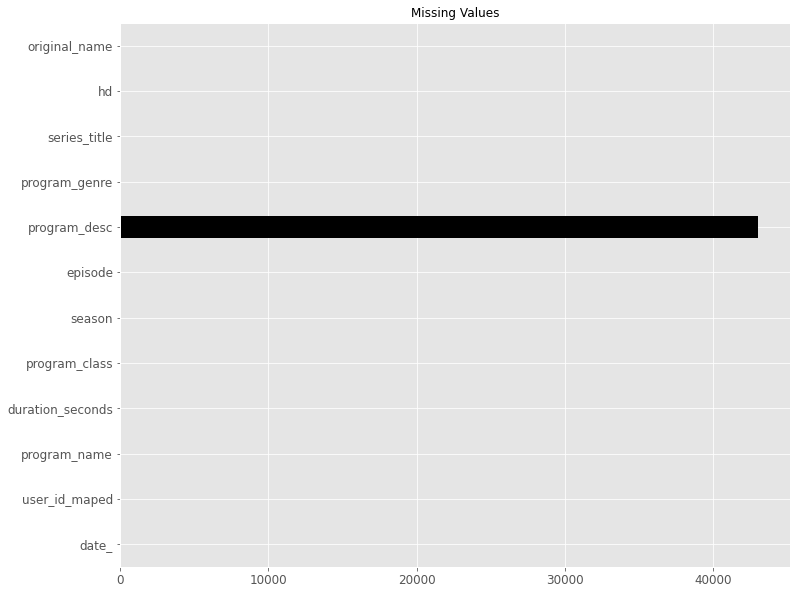

In [88]:
# Plot the missing values
df.isnull().sum().plot(kind = "barh", color = "k"); plt.title("Missing Values");

# Save the plot 
plt.savefig('plot1.png',bbox_inches='tight', dpi= 150)

In [89]:
df["program_desc"].isnull().sum()

42992

In [90]:
# Handle NaN
#fill NaN with most frequent program desc
df["program_desc"] = df["program_desc"].fillna(df["program_desc"].value_counts().index[0])

In [91]:
Users = df["user_id_maped"].unique().tolist()
len(Users)

28926

In [92]:
# Save data after handle NaN
df.to_csv("dataset.csv",index=False)

In [93]:
# shuffle users ID's
random.shuffle(Users)

# extract 90% of users ID's
Users_train = [Users[i] for i in range(round(0.9*len(Users)))]

# split data into train and validation set
train_df = df[df['user_id_maped'].isin(Users_train)]
validation_df = df[~df['user_id_maped'].isin(Users_train)]

In [94]:
# list to capture Whatching history of the users
Whatching_train = []

# populate the list with the Program name
for i in tqdm(Users_train):
    temp = train_df[train_df["user_id_maped"] == i]["original_name"].tolist()
    Whatching_train.append(temp)

100%|██████████| 26033/26033 [02:20<00:00, 185.94it/s]


In [95]:
# list to capture Whatching history of the users
Whatching_val = []

# populate the list with the Program name
for i in tqdm(validation_df['user_id_maped'].unique()):
    temp = validation_df[validation_df["user_id_maped"] == i]["original_name"].tolist()
    Whatching_val.append(temp)

100%|██████████| 2893/2893 [00:02<00:00, 1063.96it/s]


In [96]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(Whatching_train, progress_per=200)

model.train(Whatching_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(21815130, 31133860)

In [97]:
model.init_sims(replace=True)

In [98]:
print(model)

Word2Vec(vocab=1784, size=100, alpha=0.03)


In [99]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(1784, 100)

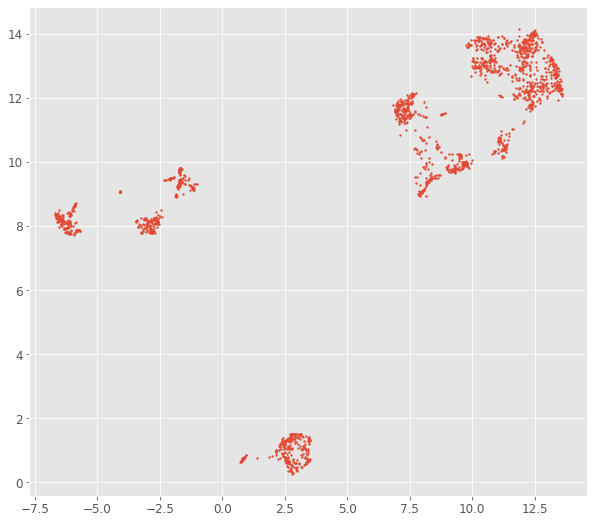

In [100]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [101]:
Program = train_df[["original_name", "program_desc"]]

# remove duplicates
Program.drop_duplicates(inplace=True, subset='original_name', keep="last")

# create Program name and Program-description dictionary
Program_dict = Program.groupby('original_name')['program_desc'].apply(list).to_dict()

In [102]:
def similar_Program(v, n = 6):
    
    # extract most similar Program for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar Program
    new_ms = []
    for j in ms:
        pair = (Program_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms     

In [103]:
def aggregate_vectors(Program):
    program_vec = []
    for i in Program:
        try:
            program_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(program_vec, axis=0)

In [104]:
len(Whatching_val[0])

1

In [105]:
aggregate_vectors(Whatching_val[0]).shape

(100,)

In [106]:
similar_Program(aggregate_vectors(Whatching_val[0]))

[("Action MovieAssassin's Creed (HD)", 0.803697407245636),
 ('Animation MovieThe Boss Baby (HD)', 0.7418460845947266),
 ('Drama Movie100 Streets (HD)', 0.7020881175994873),
 ('Comedy MovieWhy Him (HD)', 0.6842963695526123),
 ("Animation MovieSurf's Up 2: WaveMania (HD)", 0.6529399156570435),
 ("Horror MovieThe Devil's Candy (HD)", 0.6528822183609009)]

In [107]:
similar_Program(aggregate_vectors(Whatching_val[0][-10:]))

[("Action MovieAssassin's Creed (HD)", 0.803697407245636),
 ('Animation MovieThe Boss Baby (HD)', 0.7418460845947266),
 ('Drama Movie100 Streets (HD)', 0.7020881175994873),
 ('Comedy MovieWhy Him (HD)', 0.6842963695526123),
 ("Animation MovieSurf's Up 2: WaveMania (HD)", 0.6529399156570435),
 ("Horror MovieThe Devil's Candy (HD)", 0.6528822183609009)]